# Técnica: MRPC (Microsoft Research Paraphrase Corpus) usando Transformers (Hugging Face)

En este notebook se utilizan los transformers Hugging Face modelo BERT sobre el corpus MRPC para evaluar los datasets de la competición: training, evaluación y tests.  
 
En cada fase, se obtuvo un F1 score sobre la clase positiva (paráfrasis) y un tiempo de tratamiento, como se indica en la tabla: 

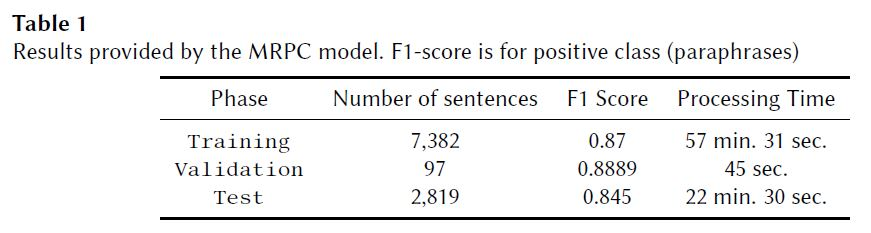

Source book: Transformers for Natural Language Processing - Second Edition
Denis Rothman, Antonio Gulli / Published by Packt Publishing
Natural Language Processing

Disponible en linea en la biblioteca UC3M: 
https://learning.oreilly.com/library/view/transformers-for-natural/9781803247335/?ar= 


## Instalación de librerías

In [1]:
# Instalar las librerías Transformers HuggingFace 

!pip3 install transformers numpy torch sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.1 MB/s 
     |████████████████████████████████| 101 kB 2.2 MB/s 
     |████████████████████████████████| 6.6 MB 36.1 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=0f7b8476a3b1b7127c4c5dd72e336a1054b908078713f0969114a241d5996797
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


## Ejemplo unitario con 2 frases 

Por ej.
* sequence_A = "sin embargo, para cuidar de la salud, se deberían comer ciertos alimentos y restringir otros cuantos."
* sequence_B = "el cuidado de la salud se debería de mantener comiendo ciertos alimentos y mantener restricciones con unos cuantos."

El resultado de la evaluación es la probabilidad obtenida en cada clase, para el ejemplo sería:
* not paraphrase: 10%
* is paraphrase: 90%

Las frases corresponden a una parafrasis con una probabilidad de 90%. 

In [2]:
# Clasificación de parafrasis. 

#  Se cargan las librerias correspondientes 
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

# Se inicializa el tokenizer a partir del modelo pre-entrenado y el modelo BERT MRPC. 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")

# Se declaran las 2 clases esperadas e inicializan las frases para el ejemplo unitario 
classes = ["not paraphrase", "is paraphrase"]
sequence_A = "sin embargo, para cuidar de la salud, se deberían comer ciertos alimentos y restringir otros cuantos."
sequence_B = "el cuidado de la salud se debería de mantener comiendo ciertos alimentos y mantener restricciones con unos cuantos."

# Se evaluan las 2 frases  y se obtiene el resultado 
paraphrase = tokenizer.encode_plus(sequence_A, sequence_B, return_tensors="tf")
paraphrase_classification_logits = model(paraphrase)[0]
paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]

# Se imprime la probabilidad de pertenecer a cada clase, obtenida como resultado 
for i in range(len(classes)):
    print(f"{classes[i]}: {round(paraphrase_results[i] * 100)}%")

Some layers from the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing TFBertForSequenceClassification: ['dropout_183']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert-base-cased-finetuned-mrpc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


not paraphrase: 10%
is paraphrase: 90%


In [3]:
# Se define la funcion calcul_result para evaluar el resultado de cada predicción e retornar de manera binaria si se trata de una parafrasis o no 

def calcul_result(paraphrase_results):

  # we know classes = ["not paraphrase", "is paraphrase"] 
  p_non_paraphrase=paraphrase_results[0]
  p_paraphrase=paraphrase_results[1]

  result_idx=0 if p_non_paraphrase>p_paraphrase else 1

  #print(p_non_paraphrase, p_paraphrase, result_idx)

  return result_idx 

# Proyecto de competencia PAR_MEX

Se cargan las librerias y se accede a las carpetas del drive donde se encuentran los datasets

In [4]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Ejecutando MRPC con el dataset de train actualizado (new)

In [6]:
sst_home='drive/My Drive/TFM/'

data_a = pd.read_csv(sst_home+"Data/new_parmex_train.csv") # 7382
data_a = data_a.dropna()

data_b = pd.read_csv(sst_home+"Data/translated_train.tsv", sep='\t') # 49129
data_b = data_b.dropna()
data_b = data_b.reset_index(drop=True)
data_b = data_b.rename(columns={'label': 'Label', 'sentence1': 'Text1', 'sentence2': 'Text2'})

df_pos = data_b[data_b["Label"] == 1].sample(10000, random_state=1)


print(len(data_a))
print(len(df_pos))

7382
10000


In [ ]:
df_train = pd.concat([
    data_a, 
    df_pos]).reset_index(drop=True)

df_train = df_train.sample(
    frac=1,
    random_state=1).reset_index(drop=True)

print(df_train.columns)
print(df_train.index)

Index(['id', 'Text1', 'Text2', 'Label'], dtype='object')
RangeIndex(start=0, stop=17382, step=1)


17382
Positivos = 11282
Negativos = 6100
----------------------------


([<matplotlib.patches.Wedge at 0x7fe3dd771250>,
 [Text(0.49649995100868205, 0.9815741432252464, 'Negative'),
  Text(-0.4964998591070757, -0.9815741897109225, 'Positive')])

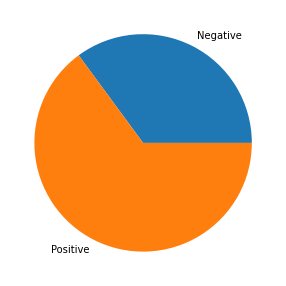

In [ ]:
import matplotlib.pyplot as plt
print(len(df_train))

print("Positivos =", len(df_train[df_train["Label"] == 1]))
print("Negativos =", len(df_train[df_train["Label"] == 0]))
print("----------------------------")

fig = plt.figure(figsize =(5, 5))
plot_data = [len(df_train[df_train["Label"] == 0]), len(df_train[df_train["Label"] == 1])]
plt.pie(plot_data, labels = ["Negative", "Positive"])

In [7]:
# Se recuperan las frases y las etiquetas del dataset de entrenamiento 

sequence_A = data_a["Text1"]
sequence_B = data_a["Text2"]
Y = data_a["Label"]

print(len(sequence_A), len(sequence_B), len(Y))

7382 7382 7382


In [ ]:
# Se recuperan las frases y las etiquetas del dataset de entrenamiento 

sequence_A = df_train["Text1"]
sequence_B = df_train["Text2"]
Y = df_train["Label"]

print(len(sequence_A), len(sequence_B), len(Y))

17382 17382 17382


In [ ]:
Y_predict=[]

for i in range(50):  
  paraphrase = tokenizer.encode_plus(sequence_A[i], sequence_B[i], return_tensors="tf")
  paraphrase_classification_logits = model(paraphrase)[0]
  paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]

  print(sequence_A[i])
  print(sequence_B[i])
  print("SHOULD:", Y[i])
  res = calcul_result(paraphrase_results)
  print("PREDICTION", res)

  Y_predict.append(res) 



In [ ]:
print( classification_report(Y[:50], Y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.54      1.00      0.70        27

    accuracy                           0.54        50
   macro avg       0.27      0.50      0.35        50
weighted avg       0.29      0.54      0.38        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Se cargan las librerias de hugging face para el modelo mrpc, utilizando los transformers 

In [8]:
#Se inicializa el modelo BERT Hugging Face MRPC 

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]


Some layers from the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing TFBertForSequenceClassification: ['dropout_183']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert-base-cased-finetuned-mrpc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Se calcula el vector de predicciones utilizando las frases del dataset de entrenamiento 

In [ ]:
missing = 0
missed_in = []
for i in range(10000):
  try:
    aux = Y[i]
  except:
    print("INDEX MISSING:", i)
    missing += 1
    missed_in.append(i)

missing

0

In [9]:
Y_predict=[]

for i in range(len(sequence_A)):  
#for i in range(10):  
  paraphrase = tokenizer.encode_plus(sequence_A[i], sequence_B[i], return_tensors="tf")
  paraphrase_classification_logits = model(paraphrase)[0]
  paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
  Y_predict.append(calcul_result(paraphrase_results)) 



In [10]:
# PAR-MEX
print( classification_report(Y, Y_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6100
           1       0.94      0.81      0.87      1282

    accuracy                           0.96      7382
   macro avg       0.95      0.90      0.92      7382
weighted avg       0.96      0.96      0.96      7382



In [ ]:
# PAW-X

In [ ]:
# PAW-MEX 17K
print( classification_report(Y, Y_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6100
           1       0.99      0.98      0.98     11282

    accuracy                           0.98     17382
   macro avg       0.98      0.98      0.98     17382
weighted avg       0.98      0.98      0.98     17382



Text(0.5, 0, 'predicted label')

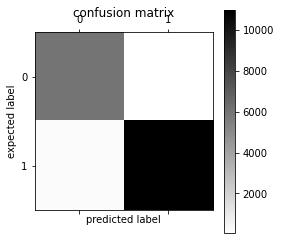

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(confusion_matrix(Y, Y_predict), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
print( classification_report(Y, Y_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6100
           1       0.94      0.81      0.87      1282

    accuracy                           0.96      7382
   macro avg       0.95      0.90      0.92      7382
weighted avg       0.96      0.96      0.96      7382



In [ ]:
Y_predict=[]

for i in range(len(sequence_A)):  
#for i in range(5):  
  paraphrase = tokenizer.encode_plus(sequence_A[i], sequence_B[i], return_tensors="tf")
  paraphrase_classification_logits = model(paraphrase)[0]
  paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
  Y_predict.append(calcul_result(paraphrase_results)) 



# PAW-MEX

In [ ]:
print( classification_report(Y, Y_predict))


              precision    recall  f1-score   support

           0       0.95      0.18      0.30     34638
           1       0.45      0.99      0.62     23873

    accuracy                           0.51     58511
   macro avg       0.70      0.58      0.46     58511
weighted avg       0.75      0.51      0.43     58511



# PAR-MEX

In [ ]:
# Verificamos las predicciones con el conjunto de labels esperados 
print( classification_report(Y, Y_predict))


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6100
           1       0.94      0.81      0.87      1282

    accuracy                           0.96      7382
   macro avg       0.95      0.90      0.92      7382
weighted avg       0.96      0.96      0.96      7382



# 2. Ejecutando MRPC con el dataset de validación 

In [ ]:
#Se carga el dataset de validación 

df_val = pd.read_csv(sst_home+"/PARMEX_2022-main-new/new_parmex_val.csv")

df_val.head()

seq_val_A = df_val["Text1"]
seq_val_B = df_val["Text2"]

print(len(seq_val_A), len(seq_val_B))

97 97


In [ ]:
#Se inicializa el modelo BERT Hugging Face MRPC 

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]


Some layers from the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing TFBertForSequenceClassification: ['dropout_183']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert-base-cased-finetuned-mrpc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Se evaluan las frases del dataset utilizando las librerias correspondientes del modelo MRPC 

Y_val=[]

for i in range(len(seq_val_A)):  
  paraphrase = tokenizer.encode_plus(seq_val_A[i], seq_val_B[i], return_tensors="tf")
  paraphrase_classification_logits = model(paraphrase)[0]
  paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
  # LAs 2 phrases  
  #print(i, seq_val_A[i], seq_val_B[i])
  # Corresponde al valor estimado  
  Y_val.append(calcul_result(paraphrase_results)) 

#Se escriben los resultados en el formato esperado por la competición en una archivo de salida txt 

with open(sst_home+'/RESULT-RUN/validacion-eval_new_MRPC.txt', 'w', encoding="utf8") as f:
  for idx in range(len(Y_val)):  
    result='"P"' if Y_val[idx] == 1 else '"NP"'
    line='"ParaphraseIdentification"'+'\t"'+str(idx+1)+'"\t'+result
    
    #print(line)
    f.write(line)
    f.write('\n')

# 3. Ejecutando MRPC con el dataset de test 

In [ ]:
#Se carga el dataset de test 

df_test = pd.read_csv(sst_home+"/PARMEX_2022-main-new/new_parmex_test.csv")

df_test.head()

seq_test_A = df_test["Text1"]
seq_test_B = df_test["Text2"]

print(len(seq_test_A), len(seq_test_B))

2819 2819


In [ ]:
#Se inicializa el modelo BERT Hugging Face MRPC 

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]


In [ ]:
# Se evaluan las frases del dataset utilizando las librerias correspondientes del modelo MRPC 

Y_test=[]

for i in range(len(seq_test_A)):  
  paraphrase = tokenizer.encode_plus(seq_test_A[i], seq_test_B[i], return_tensors="tf")
  paraphrase_classification_logits = model(paraphrase)[0]
  paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
  # LAs 2 phrases  
  #print(i, seq_test_A[i], seq_test_B[i])
  # Corresponde al valor estimado  
  Y_test.append(calcul_result(paraphrase_results))


# Se escriben directamente en el archivo de salida con el formato de la competición  

with open(sst_home+'/RESULT-RUN/resultado-MRPC_new.txt', 'w', encoding="utf8") as f:
  for idx in range(len(Y_test)):  
    result='"P"' if Y_test[idx] == 1 else '"NP"'
    line='"ParaphraseIdentification"'+'\t"'+str(idx+1)+'"\t'+result
    
    #print(line)
    f.write(line)
    f.write('\n') 